# Splitting, Preprocessing and Model Development
This notebook is used for:


### Declaring Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm, Normalize
import sklearn
import time
import datetime
import joblib
import warnings
from sklearn.model_selection import ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

### Color Palette & Typeface Sizing

In [2]:
YELLOW = '#F2DC5D'
GREEN = '#9BC53D'
DARK_GREEN = '#597222'
RED = '#C3423F'
LIGHT_BLUE = '#2596BE'
GRAY = '#666666'

AXIS_SIZE = 12
TITLE_SIZE = 16
DESCRIPTION_SIZE = 9
FIGURE_SIZE = (10*2/3,6*2/3)

RANDOM_STATE = 14

### Import Dataframe

In [3]:
#****************************************************import dataset****************************************************
df = pd.read_csv('../data/final.csv', dtype={'citizen': 'string', 'sex': 'string', 'age': 'string', 'decision': 'string', 'geo': 'string', 'TIME_PERIOD': 'string', 'GENCONV': "Int64", 'HUMSTAT': "Int64", 'SUB_PROT': "Int64", 'REJECTED': "Int64", 'TOTAL_POS': "Int64", 'TOTAL_APPS': "Int64", "POS_RATE": "Float64"}, keep_default_na=False, na_values=['nan'])

##remove partial 2023-Q3 Data
df = df[df["TIME_PERIOD"] != "2023-Q3"]

df

,citizen,sex,age,geo,TIME_PERIOD,GENCONV,HUMSTAT,SUB_PROT,REJECTED,TOTAL_POS,TOTAL_APPS
0,AD,F,UNK,AT,2008-Q1,0,0,0,0,0,0
1,AD,F,UNK,AT,2008-Q2,0,0,0,0,0,0
2,AD,F,UNK,AT,2008-Q3,0,0,0,0,0,0
3,AD,F,UNK,AT,2008-Q4,0,0,0,0,0,0
4,AD,F,UNK,AT,2009-Q1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7221109,ZW,UNK,Y_LT14,UK,2019-Q3,0,0,0,0,0,0
7221110,ZW,UNK,Y_LT14,UK,2019-Q4,0,0,0,0,0,0
7221111,ZW,UNK,Y_LT14,UK,2020-Q1,0,0,0,0,0,0
7221112,ZW,UNK,Y_LT14,UK,2020-Q2,0,0,0,0,0,0


## 1. Introduce Lagged Features

In [4]:
#****************************************************re-sort dataframe****************************************************

sort_order = ['citizen', 'sex', 'age', 'geo', 'TIME_PERIOD']
df = df.sort_values(by =sort_order) 

#*********************************************create sequential list of quarters****************************************************

quarters = []
for i in range(2008, 2024):
    quarters.append(str(i) + "-Q1")
    quarters.append(str(i) + "-Q2")
    quarters.append(str(i) + "-Q3")
    quarters.append(str(i) + "-Q4")

#****************************************************lagged features****************************************************

QUARTERS_OF_LAG = (4 * 1)

def add_lagged_features(df, features, maintained_columns, QUARTERS_OF_LAG):
    quarters = np.unique(df["TIME_PERIOD"])
    def lagged_features(target_var, lag_count, unit):
        lagged = pd.DataFrame()
        columns = []
        for i in range(1, lag_count + 1):
            lagged = pd.concat([lagged, target_var.shift(i)], axis=1)
            name = target_var.name
            if (i == 1):
                columns.append(name + " - lag " + str(i) + " " + str(unit))
            else:
                columns.append(name + " - lag " + str(i) + " " + str(unit) + "s")
        lagged.columns = columns
        return lagged.astype('Int64')

    #introduce lag for each feature
    df_lagged = df
    for f in features:
        df_lagged = pd.concat([df_lagged, lagged_features(df[f], QUARTERS_OF_LAG, "quarter")], axis=1)

    #remove all features with less than the lag amount of historical data
    #df_lagged = df_lagged[df_lagged.eq()]
    for i in range(0, QUARTERS_OF_LAG):
        shift_eq = df_lagged.eq(df_lagged.shift())
        keep = shift_eq[maintained_columns[0]]
        for j in range(1, len(maintained_columns)):
            keep = keep & shift_eq[maintained_columns[j]]
        df_lagged = df_lagged[keep]
        #print("lagged i" + str(i) + " of " + str(QUARTERS_OF_LAG))
    
    return df_lagged

df_lagged = add_lagged_features(df, ["TOTAL_POS", "TOTAL_APPS"], ['citizen', 'age', 'sex', 'geo'], QUARTERS_OF_LAG)

df_lagged

,citizen,sex,age,geo,TIME_PERIOD,GENCONV,HUMSTAT,SUB_PROT,REJECTED,TOTAL_POS,TOTAL_APPS,TOTAL_POS - lag 1 quarter,TOTAL_POS - lag 2 quarters,TOTAL_POS - lag 3 quarters,TOTAL_POS - lag 4 quarters,TOTAL_APPS - lag 1 quarter,TOTAL_APPS - lag 2 quarters,TOTAL_APPS - lag 3 quarters,TOTAL_APPS - lag 4 quarters
4,AD,F,UNK,AT,2009-Q1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,AD,F,UNK,AT,2009-Q2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,AD,F,UNK,AT,2009-Q3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,AD,F,UNK,AT,2009-Q4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,AD,F,UNK,AT,2010-Q1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7221109,ZW,UNK,Y_LT14,UK,2019-Q3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7221110,ZW,UNK,Y_LT14,UK,2019-Q4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7221111,ZW,UNK,Y_LT14,UK,2020-Q1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7221112,ZW,UNK,Y_LT14,UK,2020-Q2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Lagged Feature Testing

In [5]:
#***********************************************testing equivalence function****************************************************
def equivalent_dfs(df1, df2):
    return (df1.reset_index(drop=True) == df2.reset_index(drop=True)).all().all()

#****************************************************lagging testing****************************************************
print("[*] testing lagging function")
#simple tests
tdf0_data = [['AR', 1, 1], ['AR', 2, 2], ['AR', 3, 3], ['AR', 4, 4], ['AR', 5, 5]]
tdf0 = pd.DataFrame(data=tdf0_data, columns=['citizen', 'TIME_PERIOD', 'val'])
tdf1_data = [['AR', 2, 2, 1], ['AR', 3, 3, 2], ['AR', 4, 4, 3], ['AR', 5, 5, 4]]
tdf1 = pd.DataFrame(data=tdf1_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter'])
tdf2_data = [['AR', 3, 3, 2, 1], ['AR', 4, 4, 3, 2], ['AR', 5, 5, 4, 3]]
tdf2 = pd.DataFrame(data=tdf2_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter', 'val - lag 2 quarters'])
tdf3_data = [['AR', 4, 4, 3, 2, 1], ['AR', 5, 5, 4, 3, 2]]
tdf3 = pd.DataFrame(data=tdf3_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter', 'val - lag 2 quarters', 'val - lag 3 quarters'])

assert equivalent_dfs(add_lagged_features(tdf0, ["val"], ['citizen'], 1), 
                      tdf1), "basic lag test failed, shift=1"
assert equivalent_dfs(add_lagged_features(tdf0, ["val"], ['citizen'], 2), 
                      tdf2), "basic lag test failed, shift=2"
assert equivalent_dfs(add_lagged_features(tdf0, ["val"], ['citizen'], 3), 
                      tdf3), "basic lag test failed, shift=3"
print("\t[+] basic lag tests passed")

#more advanced tests
tdf4_data = [['AU', 1, 1], ['AU', 2, 2], ['AU', 3, 3], ['AU', 4, 4], ['AU', 5, 5],
             ['NZ', 1, 11], ['NZ', 2, 12], ['NZ', 3, 13], ['NZ', 4, 14], ['NZ', 5, 15]]
tdf4 = pd.DataFrame(data=tdf4_data, columns=['citizen', 'TIME_PERIOD', 'val'])
tdf5_data = [['AU', 2, 2, 1], ['AU', 3, 3, 2], ['AU', 4, 4, 3], ['AU', 5, 5, 4],
             ['NZ', 2, 12, 11], ['NZ', 3, 13, 12], ['NZ', 4, 14, 13], ['NZ', 5, 15, 14]]
tdf5 = pd.DataFrame(data=tdf5_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter'])
tdf6_data = [['AU', 3, 3, 2, 1], ['AU', 4, 4, 3, 2], ['AU', 5, 5, 4, 3],
             ['NZ', 3, 13, 12, 11], ['NZ', 4, 14, 13, 12], ['NZ', 5, 15, 14, 13]]
tdf6 = pd.DataFrame(data=tdf6_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter', 'val - lag 2 quarters'])


assert equivalent_dfs(add_lagged_features(tdf4, ["val"], ['citizen'], 1), 
                      tdf5), "lag with shared times test failed, shift=1"
assert equivalent_dfs(add_lagged_features(tdf4, ["val"], ['citizen'], 2), 
                      tdf6), "lag with shared times test failed, shift=2"
print("\t[+] tests with shared times passed")

#very complicated tests
tdf7_data = [['AU', 1, 1], ['AU', 2, 2], ['AU', 3, 3], ['AU', 4, 4], ['AU', 5, 5],
             ['NZ', 2, 12], ['NZ', 3, 13], ['NZ', 4, 14], ['NZ', 5, 15]]
tdf7 = pd.DataFrame(data=tdf7_data, columns=['citizen', 'TIME_PERIOD', 'val'])
tdf8_data = [['AU', 2, 2, 1], ['AU', 3, 3, 2], ['AU', 4, 4, 3], ['AU', 5, 5, 4],
             ['NZ', 3, 13, 12], ['NZ', 4, 14, 13], ['NZ', 5, 15, 14]]
tdf8 = pd.DataFrame(data=tdf8_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter'])
tdf9_data = [['AU', 3, 3, 2, 1], ['AU', 4, 4, 3, 2], ['AU', 5, 5, 4, 3],
             ['NZ', 4, 14, 13, 12], ['NZ', 5, 15, 14, 13]]
tdf9 = pd.DataFrame(data=tdf9_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter', 'val - lag 2 quarters'])
tdf10_data = [['AU', 1, 1], ['AU', 2, 2], ['AU', 3, 3], ['AU', 4, 4], ['AU', 5, 5],
              ['NZ', 2, 12], ['NZ', 3, 13], ['NZ', 4, 14], ['NZ', 5, 15],
              ['FJ', 3, 23], ['FJ', 4, 24], ['FJ', 5, 25], ['FJ', 6, 26], ['FJ', 7, 27], ['FJ', 8, 28],
              ['WS', 4, 34], ['WS', 5, 35]]
tdf10 = pd.DataFrame(data=tdf10_data, columns=['citizen', 'TIME_PERIOD', 'new_val'])
tdf11_data = [['AU', 2, 2, 1], ['AU', 3, 3, 2], ['AU', 4, 4, 3], ['AU', 5, 5, 4],
              ['NZ', 3, 13, 12], ['NZ', 4, 14, 13], ['NZ', 5, 15, 14],
              ['FJ', 4, 24, 23], ['FJ', 5, 25, 24], ['FJ', 6, 26, 25], ['FJ', 7, 27, 26], ['FJ', 8, 28, 27],
              ['WS', 5, 35, 34]]
tdf11 = pd.DataFrame(data=tdf11_data, columns=['citizen', 'TIME_PERIOD', 'new_val', 'new_val - lag 1 quarter'])
tdf12_data = [['AU', 5, 5, 4, 3, 2, 1],
              ['FJ', 7, 27, 26, 25, 24, 23], ['FJ', 8, 28, 27, 26, 25, 24]]
tdf12 = pd.DataFrame(data=tdf12_data, columns=['citizen', 'TIME_PERIOD', 'new_val', 'new_val - lag 1 quarter', 'new_val - lag 2 quarters', 'new_val - lag 3 quarters', 'new_val - lag 4 quarters'])

assert equivalent_dfs(add_lagged_features(tdf7, ["val"], ['citizen'], 1), 
                      tdf8), "lag with 2 different start times test failed, shift=1"
assert equivalent_dfs(add_lagged_features(tdf7, ["val"], ['citizen'], 2), 
                      tdf9), "lag with 2 different start times test failed, shift=2"
assert equivalent_dfs(add_lagged_features(tdf10, ["new_val"], ['citizen'], 1), 
                      tdf11), "lag with many different start times test failed, shift=1"
assert equivalent_dfs(add_lagged_features(tdf10, ["new_val"], ['citizen'], 4), 
                      tdf12), "lag with many different start times test failed, shift=4"
print("\t[+] tests with multiple start and end dates passed")

print("\t[+] \x1b[42mPASSED ALL\x1b[0m lagging tests")

[*] testing lagging function
	[+] basic lag tests passed
	[+] tests with shared times passed
	[+] tests with multiple start and end dates passed
	[+] PASSED ALL lagging tests


## 2. Dataset Splitting

In [6]:
#****************************************************splitting****************************************************
TARGET_VAR = "TOTAL_POS"

y = df_lagged[TARGET_VAR]
X = df_lagged.drop(['GENCONV', 'HUMSTAT', 'SUB_PROT', 'REJECTED', 'TOTAL_POS'], axis=1)
#PLAN:
#of 62 quarters...
#QUARTERS_OF_LAG are lost bc they wont have the needed lagged features
    
new_quarters = [q for q in quarters if q >= quarters[QUARTERS_OF_LAG]]
quarter_count = len(new_quarters) - 1

TRAIN_PORTION = 0.6
VAL_PORTION = 0.2
TEST_PORTION = 0.2

#take out last portion of quarters for testing
#div_0 = new_quarters[0]
#div_1 = new_quarters[int(quarter_count * train_split)]
div_2 = new_quarters[int(quarter_count * (1 - TEST_PORTION))]
div_3 = new_quarters[quarter_count]

#seperate out test section
X_test = X[(div_2 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_3)]
y_test = y[(div_2 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_3)]

### Evaluation Functions (for cross-validation)

In [7]:
def RMSE(y_pred, y_true):
    return np.sqrt(((y_pred - y_true) ** 2).sum() / len(y_pred))

def BASELINE_RMSE(y_true):
    return ALL_ZERO_BASELINE(y_true)

def ALL_ZERO_BASELINE(y_true):
    return np.sqrt(((y_true) ** 2).sum() / len(y_true))

def ALL_ONE_BASELINE(y_true):
    return np.sqrt(((1 - y_true) ** 2).sum() / len(y_true))

def ALL_MEAN_BASELINE(y_train, y_true):
    mean = y_train.mean()
    return np.sqrt(((mean - y_true) ** 2).sum() / len(y_true))

### Helper Functions

In [8]:
def TIMESTAMP_STR():
    dt = datetime.datetime.now()
    txt = "{hour}:{minute:02.0f} on {day}-{month}-{year}"
    return txt.format(hour=dt.hour, minute=dt.minute, day=dt.day, month=dt.month, year=dt.year)

def DF_ALL_PREDICTED(model):
    df_new = df
    df_new["TOTAL_APPS_PRED"] = model.predict(X)

UPDATE = True
def Status_Update(t, message):
    my_time = time.time()
    if UPDATE:
        print(str(message) + " \t-- in " + str(time.time() - t) + "s")
    return time.time()

### General Model-Training Function

In [213]:
def MLPipe_TimeSeries_RMSE(X, y, preprocessor, ML_algo, param_grid):
    ALGO_NAME = str(ML_algo)[str(ML_algo).rindex('.')+1:-2]
    MODEL_NAME = "{algo}({time})".format(algo=ALGO_NAME, time=TIMESTAMP_STR())
    NUM_FOLDS = np.round(TRAIN_PORTION / VAL_PORTION).astype(int)
    RANDOM_STATE = 14
    print("[!] looking at model: " + str(MODEL_NAME))
    
    print("\t[*] doing initial dataset splitting")
    
    #opt check 2
    X_trains = []
    y_trains = []
    X_vals = []
    y_vals = []
    for i in range(1, NUM_FOLDS + 1):
        train_portion = np.round(i * VAL_PORTION, 2)
        div_0 = new_quarters[0]
        div_1 = new_quarters[int(quarter_count * train_portion)]
        div_2 = new_quarters[int(quarter_count * (train_portion + VAL_PORTION))]

        X_trains.append(X[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
        y_trains.append(y[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
        X_vals.append(X[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])
        y_vals.append(y[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])
        print("\t\t[+] fold " + str(i))
    
    param_scores = []
    param_models = []
    for p in param_grid:
        T_PARAM_START = time.time()
        fold_scores = []
        print("\t[*] looking at hyperparameters " + str(p))
        for i in range(NUM_FOLDS, NUM_FOLDS + 1):
            T_FOLD_START = time.time()
            #ADD OPTIMIZATION HERE:
                #[2] NO NEED TO CONSTANTLY REDIVIDE THE DATA, SAME THREE FOLDS WILL BE USED EACH TIME REGARDLES OF HYPERPARAMAETERS
                #[1] NO NEED TO CHECK FUTURE FOLDS IF EVEN A SCORE OF ZERO WOULDN'T BRING IT BELOW A BETTER FOUND PARAMETER ARRANGEMENT
            train_portion = np.round(i * VAL_PORTION, 2)
            
            #opt check 1
            if (i > 0 & len(param_scores) > 0):
                best_param_score = param_scores[np.argmin(param_scores)]
                if ((best_param_score * 3) < np.sum(fold_scores)):
                    print("[!] best average score I could get with " + str(np.sum(fold_scores)) + " score already is worse than a previous params score of " + str(best_param_score) + ", so giving up")

            mini_t = time.time()
            
            X_train = X_trains[i - 1]
            y_train = y_trains[i - 1]
            X_val = X_vals[i - 1]
            y_val = y_vals[i - 1]
            
            #PORTION_OF_POINTS = 0.001
            #X_train = X_train.sample(np.floor((len(X_train) * PORTION_OF_POINTS)).astype(int), random_state = RANDOM_STATE)
            #y_train = y_train.loc[X_train.index]
            #X_val = X_val.sample(np.floor((len(X_val) * PORTION_OF_POINTS)).astype(int), random_state = RANDOM_STATE)
            #y_val = y_val.loc[X_val.index]
            
            mini_t = Status_Update(mini_t, "split data")

            #make pipeline
            if ((ALGO_NAME == "SVR") | (ALGO_NAME == "LinearRegression") | (ALGO_NAME == "RandomForestRegressor")):
                algo = ML_algo(**p)
            else:
                algo = ML_algo(**p, random_state = RANDOM_STATE)
            
            #print(algo)
            pipe = Pipeline(steps=[
                        ('preprocess', preprocessor),
                        ('model', algo)
                    ], verbose=True)
            
            mini_t = Status_Update(mini_t, "made pipeline")

            pipe.fit(X_train, y_train)
            mini_t = Status_Update(mini_t, "fit pipeline")
            
            y_pred = pipe.predict(X_val)
            score = RMSE(y_pred, y_val)
            
            fold_scores.append(score)
            T_FOLD_END = time.time()
            T_FOLD_ELAPSED = T_FOLD_END - T_FOLD_START
            mini_t = Status_Update(mini_t, "eval pipeline")
            print("\t\t[*] fold " + str(i) + " complete (test score of " + str(score) + ") -- in " + str(np.round(T_FOLD_ELAPSED, 3)) + "s")
        score = np.mean(fold_scores)
        param_scores.append(score)
        param_models.append(pipe)
        
        T_PARAM_END = time.time()
        T_PARAM_ELAPSED = T_PARAM_END - T_PARAM_START
        print("\t\t[+] final score for params of " + str(score) + " -- in " + str(np.round(T_PARAM_ELAPSED, 3)) + "s")
        
        if (np.argmin(param_scores) == (len(param_scores) - 1)):
            best_model = param_models[np.argmin(param_scores)]
            print("\t\t[!] new best param configuration, so saving model to path")
            path = "../results/" + MODEL_NAME + ".pkl"
            joblib.dump(best_model, path, compress = 1)
            print("\t\t\t[+] saved model to " + str(path))
        
        
    i_best = np.argmin(param_scores)
    best_score = param_scores[i_best]
    best_params = param_grid[i_best]
    best_model = param_models[i_best]
    print("\t[+] best param configuration of " + str(best_params) + " found with score " + str(best_score))
    path = "../results/" + MODEL_NAME + ".pkl"
    joblib.dump(best_model, path, compress = 1)
    print("\t[+] saved model to " + str(path))


In [136]:
def TRAIN_XGBOOST(X, y, preprocessor, ML_algo, param_grid):
    ALGO_NAME = str(ML_algo)[str(ML_algo).rindex('.')+1:-2]
    MODEL_NAME = "{algo}({time})".format(algo=ALGO_NAME, time=TIMESTAMP_STR())
    NUM_FOLDS = np.round(TRAIN_PORTION / VAL_PORTION).astype(int)
    RANDOM_STATE = 14
    print("[!] looking at XGBoost model: " + str(MODEL_NAME))
    
    print("\t[*] doing initial dataset splitting")
    
    #opt check 2
    X_trains = []
    y_trains = []
    X_vals = []
    y_vals = []
    for i in range(1, NUM_FOLDS + 1):
        train_portion = np.round(i * VAL_PORTION, 2)
        div_0 = new_quarters[0]
        div_1 = new_quarters[int(quarter_count * train_portion)]
        div_2 = new_quarters[int(quarter_count * (train_portion + VAL_PORTION))]

        X_trains.append(X[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
        y_trains.append(y[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
        X_vals.append(X[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])
        y_vals.append(y[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])
        print("\t\t[+] fold " + str(i))
    
    param_scores = []
    param_models = []
    for p in param_grid:
        T_PARAM_START = time.time()
        fold_scores = []
        print("\t[*] looking at hyperparameters " + str(p))
        for i in range(1, NUM_FOLDS + 1):
            T_FOLD_START = time.time()
            #ADD OPTIMIZATION HERE:
                #[2] NO NEED TO CONSTANTLY REDIVIDE THE DATA, SAME THREE FOLDS WILL BE USED EACH TIME REGARDLES OF HYPERPARAMAETERS
                #[1] NO NEED TO CHECK FUTURE FOLDS IF EVEN A SCORE OF ZERO WOULDN'T BRING IT BELOW A BETTER FOUND PARAMETER ARRANGEMENT
            train_portion = np.round(i * VAL_PORTION, 2)
            
            #opt check 1
            if (i > 0 & len(param_scores) > 0):
                best_param_score = param_scores[np.argmin(param_scores)]
                if ((best_param_score * 3) < np.sum(fold_scores)):
                    print("[!] best average score I could get with " + str(np.sum(fold_scores)) + " score already is worse than a previous params score of " + str(best_param_score) + ", so giving up")

            mini_t = time.time()
            
            X_train = X_trains[i - 1]
            y_train = y_trains[i - 1]
            X_val = X_vals[i - 1]
            y_val = y_vals[i - 1]
            
            PORTION_OF_POINTS = 0.01
            X_train = X_train.sample(np.floor((len(X_train) * PORTION_OF_POINTS)).astype(int), random_state = RANDOM_STATE)
            y_train = y_train.loc[X_train.index]
            X_val = X_val.sample(np.floor((len(X_val) * PORTION_OF_POINTS)).astype(int), random_state = RANDOM_STATE)
            y_val = y_val.loc[X_val.index]
            
            mini_t = Status_Update(mini_t, "split data")
            
            algo = ML_algo(**p, early_stopping_rounds=50)
            
            #print(algo)
            mini_t = Status_Update(mini_t, "made pipeline")
                
            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)
            
            mini_t = Status_Update(mini_t, "preprocess data")

            algo.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
            mini_t = Status_Update(mini_t, "fit pipeline")
            
            y_pred = algo.predict(X_val)
            score = RMSE(y_pred, y_val)
            
            fold_scores.append(score)
            T_FOLD_END = time.time()
            T_FOLD_ELAPSED = T_FOLD_END - T_FOLD_START
            mini_t = Status_Update(mini_t, "eval pipeline")
            print("\t\t[*] fold " + str(i) + " complete (test score of " + str(score) + ") -- in " + str(np.round(T_FOLD_ELAPSED, 3)) + "s")
        score = np.mean(fold_scores)
        param_scores.append(score)
        param_models.append(algo)
        
        T_PARAM_END = time.time()
        T_PARAM_ELAPSED = T_PARAM_END - T_PARAM_START
        print("\t\t[+] final score for params of " + str(score) + " -- in " + str(np.round(T_PARAM_ELAPSED, 3)) + "s")
        
        path = "../results/" + MODEL_NAME + '[seed ' + str(p['seed']) + "].pkl"
        joblib.dump(algo, path, compress = 1)
        print("\t\t\t[+] saved model to " + str(path))
        #if (np.argmin(param_scores) == (len(param_scores) - 1)):
            #best_model = param_models[np.argmin(param_scores)]
            #print("\t\t[!] new best param configuration, so saving model to path")
            #path = "../results/" + MODEL_NAME + ".pkl"
            #joblib.dump(best_model, path, compress = 1)
            #print("\t\t\t[+] saved model to " + str(path))
        
        
    i_best = np.argmin(param_scores)
    best_score = param_scores[i_best]
    best_params = param_grid[i_best]
    best_model = param_models[i_best]
    print("\t[+] best param configuration of " + str(best_params) + " found with score " + str(best_score))
    path = "../results/" + MODEL_NAME + ".pkl"
    joblib.dump(best_model, path, compress = 1)
    print("\t[+] saved model to " + str(path))


### Importing Models

In [11]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

#MODELS TO TEST:
#[Q] ~LASSO
#[T] RIDGE
#[] RIDGE (poly)
#[DIED] ~ELASTIC NET
#[T/DIED] RF
#[T] SVR (linear)
#[] ~SVR (rbf) ^if linear doesnt work
#[IP] XGBoost
#[] ~KNN??

#T: Trained
#IP: In Progress
#Q: Queued

### Training Linear Models

In [12]:
LASSO_PARAM_GRID = ParameterGrid({
            'alpha': np.geomspace(0.01, 10000, 12), # no upper bound so the values are evenly spaced in log
            })

MLPipe_TimeSeries_RMSE(X, y, preprocessor, Lasso, LASSO_PARAM_GRID)

NameError: name 'preprocessor' is not defined

In [ ]:
RIDGE_PARAM_GRID = ParameterGrid({
            'alpha': np.geomspace(0.01, 10000, 12), # no upper bound so the values are evenly spaced in log
            })
RIDGE_PARAM_GRID_SMALL = ParameterGrid({
            'alpha': [0.1, 1, 10, 100], # no upper bound so the values are evenly spaced in log
            })

MLPipe_TimeSeries_RMSE(X, y, preprocessor, Ridge, RIDGE_PARAM_GRID)

In [ ]:
ELASTIC_PARAM_GRID = {
            'model__alpha': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000], # no upper bound so the values are evenly spaced in log
            'model__l1_ratio': np.linspace(0.2, 1, 9)
            }

MLPipe_TimeSeries_RMSE(X, y, preprocessor, ElasticNet, ELASTIC_PARAM_GRID)

### Training Non-Linear Models

In [ ]:
RF_PARAM_GRID = ParameterGrid({
            'max_depth': [1, 3, 4, 7, 10, 14, 21, 31], # no upper bound so the values are evenly spaced in log
            'max_features': np.linspace(0.2, 1, 5)
            })


MLPipe_TimeSeries_RMSE(X, y, preprocessor, RandomForestRegressor, RF_PARAM_GRID)

In [214]:
for i in [0, 1, 2, 3]:
    print("WORKING ON #" + str(i))
    RF_PARAM_GRID_VERY_SMALL = ParameterGrid({
            'max_depth': [10], # no upper bound so the values are evenly spaced in log
            #'max_features': [1],
            'random_state': [i]
            })
    MLPipe_TimeSeries_RMSE(X, y, preprocessor, RandomForestRegressor, RF_PARAM_GRID_VERY_SMALL)

WORKING ON #0
[!] looking at model: RandomForestRegressor(19:11 on 4-12-2023)
	[*] doing initial dataset splitting
		[+] fold 1
		[+] fold 2
		[+] fold 3
	[*] looking at hyperparameters {'max_depth': 10, 'random_state': 0}
split data 	-- in 5.3882598876953125e-05s
made pipeline 	-- in 0.0003750324249267578s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=  13.0s


KeyboardInterrupt: 

In [ ]:
RIDGE_PARAM_GRID_POLY = ParameterGrid({
            'alpha': np.geomspace(0.01, 10000, 12), # no upper bound so the values are evenly spaced in log
            #'normalize': [True]
            })
EMPTY = ParameterGrid({
            'alpha': np.geomspace(0.01, 10000, 12), # no upper bound so the values are evenly spaced in log
            #'normalize': [True]
            })


#MLPipe_TimeSeries_RMSE(X, y, preprocessor_poly, Ridge, RIDGE_PARAM_GRID_POLY)

In [23]:
import xgboost

#trying hyperparameter space

XGB_PARAM_GRID = ParameterGrid({
    "learning_rate": [0.03],
    "n_estimators": [1000],
    #"early_stopping_rounds": [50],
    "reg_alpha": [1e0, 1e1, 1e-1, 0, 1e-2, 1e2],
    "reg_lambda": [1e0, 1e1, 1e-1, 0, 1e-2, 1e2],
    "seed": [1956, 14, 3],
    #"max_depth": [1,3,10,30,100],
    "colsample_bytree": [0.9],              
    "subsample": [0.66]
    })

#TRAIN_XGBOOST(X, y, preprocessor, xgboost.XGBRegressor, XGB_PARAM_GRID)
#for p in XGB_PARAM_GRID:
#    print(p['seed'])

In [25]:
XGB_PARAM_GRID = ParameterGrid({
    "learning_rate": [0.03],
    "n_estimators": [1000],
    #"early_stopping_rounds": [50],
    "reg_alpha": [1],
    "reg_lambda": [1],
    "seed": range(0, 15),
    #"max_depth": [1,3,10,30,100],
    "colsample_bytree": [0.9],              
    "subsample": [0.66]
    })

TRAIN_XGBOOST(X, y, preprocessor, xgboost.XGBRegressor, XGB_PARAM_GRID)

[!] looking at XGBoost model: XGBRegressor(15:29 on 4-12-2023)
	[*] doing initial dataset splitting
		[+] fold 1
		[+] fold 2
		[+] fold 3
	[*] looking at hyperparameters {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'n_estimators': 1000, 'reg_alpha': 1, 'reg_lambda': 1, 'seed': 0, 'subsample': 0.66}
split data 	-- in 2.1457672119140625e-06s
made pipeline 	-- in 2.7894973754882812e-05s
preprocess data 	-- in 4.314434766769409s
fit pipeline 	-- in 418.08653593063354s
eval pipeline 	-- in 3.003788948059082s
		[*] fold 1 complete (test score of 4.09871849423321) -- in 425.406s
split data 	-- in 9.5367431640625e-07s
made pipeline 	-- in 0.00044608116149902344s
preprocess data 	-- in 8.737162590026855s
fit pipeline 	-- in 382.9575660228729s
eval pipeline 	-- in 2.1649160385131836s
		[*] fold 2 complete (test score of 51.44621826210352) -- in 393.861s
split data 	-- in 9.5367431640625e-07s
made pipeline 	-- in 0.0003428459167480469s
preprocess data 	-- in 12.211945056915283s
fit pipeline 

UnboundLocalError: cannot access local variable 'best_model' where it is not associated with a value

In [ ]:
X_test_partial = X_test.sample(np.floor((len(X_test) * 0.3)).astype(int))
y_test_partial = y_test.loc[X_test_partial.index]
y_test_partial

In [ ]:
X_trains = []
y_trains = []
X_vals = []
y_vals = []
for i in range(1, 3 + 1):
    train_portion = np.round(i * VAL_PORTION, 2)
    div_0 = new_quarters[0]
    div_1 = new_quarters[int(quarter_count * train_portion)]
    div_2 = new_quarters[int(quarter_count * (train_portion + VAL_PORTION))]

    X_trains.append(X[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
    y_trains.append(y[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
    X_vals.append(X[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])
    y_vals.append(y[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])

In [ ]:
model = joblib.load("../results/Ridge(19:57 on 2-12-2023).pkl")
cfs = pd.DataFrame(model.named_steps["model"].coef_)
cfs.index = model.named_steps['preprocess'].get_feature_names_out()
cfs[0].sort_values(ascending=False)

In [ ]:
model = joblib.load("../results/Ridge(22:59 on 3-12-2023).pkl")
cfs = pd.DataFrame(model.named_steps["model"].coef_)
cfs.index = model.named_steps['preprocess'].get_feature_names_out()
cfs[0].sort_values(ascending=False)

In [ ]:
#old split checking
def check_split_sizes(X, train, test, val):
    fails = 0
    print("[*] checking train test val split")
    train_set_qs = set(train["TIME_PERIOD"])
    test_set_qs = set(test["TIME_PERIOD"])
    val_set_qs = set(val["TIME_PERIOD"])
    
    #check for TIME_PERIOD overlap
    shared = (train_set_qs & test_set_qs) | (val_set_qs & test_set_qs) | (train_set_qs & val_set_qs)
    if (len(shared) != 0):
        warnings.warn('\t[-] overlap between train, test, or val time_periods')
        fails+=1
    else:
        print("\t[+] no overlap between train, test, or val TIME_PERIODS")
        
    #check for a fairly even 60/20/20 split
    NAMES = ['train', 'test ', 'val  ']
    TARGETS = [0.6, 0.2, 0.2]
    ALLOWED_FRACTION_ERROR = 0.02
    sizes = [len(train) / len(X), len(test) / len(X), len(val) / len(X)]
    for i in range(0, 3):
        if (np.abs(sizes[i] - TARGETS[i]) < ALLOWED_FRACTION_ERROR):
            print("\t[+] " + str(NAMES[i]) + " is " + str(np.round(sizes[i], 3)) + " of datapoints which is within bounds of its " + str(TARGETS[i]) + " target")
        else:
            warnings.warn("\t[-] " + str(NAMES[i]) + " is " + str(np.round(sizes[i], 3)) + " of datapoints which is out of bounds")
            fails+=1

    if (fails == 0):
        print("\t[+] \x1b[42mPASSED ALL\x1b[0m train test val split tests")
    else:
        print("\t[?] \033[91mFAILED " + str(fails) + "\033[0m train test val split tests")
        

#check_split_sizes(X, X_train, X_test, X_val)

In [32]:
    X_trains = []
    y_trains = []
    X_vals = []
    y_vals = []
    for i in range(1, 3 + 1):
        train_portion = np.round(i * VAL_PORTION, 2)
        div_0 = new_quarters[0]
        div_1 = new_quarters[int(quarter_count * train_portion)]
        div_2 = new_quarters[int(quarter_count * (train_portion + VAL_PORTION))]

        X_trains.append(X[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
        y_trains.append(y[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
        X_vals.append(X[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])
        y_vals.append(y[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])

In [61]:
##calculate baselines
y_pred1 = np.zeros(len(y_test))
base_zeros = RMSE(y_pred1, y_test)

test_mean = y_trains[2].mean()
y_pred2 = [test_mean] * len(y_test)
base_test_mean = RMSE(y_pred2, y_test)

y_pred3 = X_test["TOTAL_POS - lag 1 quarter"]
base_last = RMSE(y_pred3, y_test)

In [133]:
#test models
model_ridge = joblib.load("../results/Ridge(19:57 on 2-12-2023).pkl")
model_ridge = joblib.load("../results/Ridge(20:30 on 2-12-2023).pkl") #this is the better updated ridge model
y_pred_ridge = model_ridge.predict(X_test)
score_ridge = RMSE(y_pred_ridge, y_test)

model_poly = joblib.load("../results/Ridge(22:58 on 3-12-2023).pkl") #this is the better updated ridge model
y_pred_poly = model_poly.predict(X_test)
score_poly = RMSE(y_pred_poly, y_test)

model_SVR = joblib.load("../results/LinearSVR(16:40 on 3-12-2023).pkl")
y_pred_SVR = model_SVR.predict(X_test)
score_SVR = RMSE(y_pred_SVR, y_test)

model_RF = joblib.load("../results/RandomForestRegressor(22:46 on 2-12-2023).pkl")
y_pred_RF = model_RF.predict(X_test)
score_RF = RMSE(y_pred_RF, y_test)

model_XGB = joblib.load("../results/XGBRegressor(0:14 on 4-12-2023).pkl")
y_pred_XGB = model_XGB.predict(preprocessor.transform(X_test))
score_XGB = RMSE(y_pred_XGB, y_test)



In [235]:
model_RF = joblib.load("../results/RandomForestRegressor(0:02 on 5-12-2023).pkl")
y_pred_RF = model_RF.predict(X_test)
score_RF = RMSE(y_pred_RF, y_test)
score_RF
#RandomForestRegressor(18:41 on 4-12-2023).pkl
#RF 14 (1:01 on 3): 7.478723543421034
#RandomForestRegressor(23:57 on 4-12-2023).pkl
#RandomForestRegressor(19:22 on 4-12-2023).pkl
#RandomForestRegressor(0:02 on 5-12-2023).pkl

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


8.326900226555534

In [222]:
model_RF

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['UNK',
                                                                              'Y_LT14',
                                                                              'Y14-17',
                                                                              'Y18-34',
                                                                              'Y35-64',
                                                                              'Y_GE65'],
                                                                             ['2008-Q1',
                                                                              '2008-Q2',
                                                                              '2008-Q3',
                                                                              '2008-Q4',
                                                                              '2009-Q1',
                                                                              '2009-Q2',
                                                                              '2009-Q3',
                                                                              '2009-Q4',
                                                                              '2010-Q1',
                                                                              '2010-Q2',
                                                                              '2010-Q3',
                                                                              '2010-Q4',
                                                                              '2011-Q1',
                                                                              '2011-Q2',
                                                                              '2011-Q3',
                                                                              '2011-Q4',
                                                                              '2012-Q1',
                                                                              '2012-Q2',
                                                                              '2012-Q3',
                                                                              '2012-Q4',...
                                                 ('minmax', MinMaxScaler(), []),
                                                 ('std', StandardScaler(),
                                                  ['TOTAL_APPS',
                                                   'TOTAL_POS - lag 1 quarter',
                                                   'TOTAL_POS - lag 2 quarters',
                                                   'TOTAL_POS - lag 3 quarters',
                                                   'TOTAL_POS - lag 4 quarters',
                                                   'TOTAL_APPS - lag 1 quarter',
                                                   'TOTAL_APPS - lag 2 '
                                                   'quarters',
                                                   'TOTAL_APPS - lag 3 '
                                                   'quarters',
                                                   'TOTAL_APPS - lag 4 '
                                                   'quarters'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=4,
                                       verbose=1))],
         verbose=True)

In [223]:
model_XGB = joblib.load("../results/XGBRegressor(23:37 on 4-12-2023)[seed 0].pkl")
y_pred_XGB = model_XGB.predict(preprocessor.transform(X_test))
score_XGB = RMSE(y_pred_XGB, y_test)
score_XGB


11.56658284379576

In [226]:
model_XGB = joblib.load("../results/XGBRegressor(23:38 on 4-12-2023)[seed 1].pkl")
y_pred_XGB = model_XGB.predict(preprocessor.transform(X_test))
score_XGB = RMSE(y_pred_XGB, y_test)
score_XGB


9.815434282889152

In [227]:
model_XGB = joblib.load("../results/XGBRegressor(23:41 on 4-12-2023)[seed 2].pkl")
y_pred_XGB = model_XGB.predict(preprocessor.transform(X_test))
score_XGB = RMSE(y_pred_XGB, y_test)
score_XGB


11.276301956704552

In [228]:
model_XGB = joblib.load("../results/XGBRegressor(23:46 on 4-12-2023)[seed 3].pkl")
y_pred_XGB = model_XGB.predict(preprocessor.transform(X_test))
score_XGB = RMSE(y_pred_XGB, y_test)
score_XGB

10.26521592121377

In [225]:
model_XGB = joblib.load("../results/XGBRegressor(0:14 on 4-12-2023).pkl")
y_pred_XGB = model_XGB.predict(preprocessor.transform(X_test))
score_XGB = RMSE(y_pred_XGB, y_test)
score_XGB

13.238935694425836

In [109]:

new_score_ridge

6.83297972421315

In [81]:
y_pred_ridge

array([-0.00811889, -0.00897357, -0.00982825, ...,  0.01093422,
        0.01007954,  0.00922486])

In [95]:
preds = pd.DataFrame(y_pred_ridge, columns=['y_pred'])
preds.index = y_test.index
preds['y_pred_other'] = new_y_pred_ridge
preds['y_true'] = y_test
preds.sort_values(by='y_true')

,y_pred,y_pred_other,y_true
51,-0.015632,-0.008119,0
4789219,-0.066426,-0.040421,0
4789218,-0.065049,-0.039566,0
4789217,-0.063672,-0.038711,0
4789216,-0.062295,-0.037857,0
...,...,...,...
6021542,4226.231932,4290.228550,5075
6033404,4648.206439,4768.429561,5620
6027475,5447.373935,5489.796611,6465
6027477,8464.580245,8701.065216,8805


In [115]:
cfs = cfs_from(new_model_ridge)
cfs[cfs.index.list.find("poly")]

AttributeError: 'Index' object has no attribute 'find'

In [120]:
cfs.filter(like='poly', axis=0)
cfs[cfs['importance'] > 0.000114]

,importance
std__TOTAL_POS - lag 1 quarter,31.977728
std__TOTAL_APPS,30.598162
std__TOTAL_POS - lag 2 quarters,8.204418
std__TOTAL_APPS - lag 3 quarters,5.849496
std__TOTAL_POS - lag 4 quarters,1.627679
...,...
onehot__sex_F,0.003342
onehot__citizen_LY,0.002634
onehot__citizen_AO,0.000991
onehot__citizen_CG,0.000830


In [211]:
cfs_from(model_poly).head(20)

,importance,abs_importance
std__TOTAL_POS - lag 1 quarter,31.977728,31.977728
std__TOTAL_APPS,30.598162,30.598162
std__TOTAL_APPS - lag 1 quarter,-21.003031,21.003031
std__TOTAL_APPS - lag 2 quarters,-9.452198,9.452198
std__TOTAL_POS - lag 2 quarters,8.204418,8.204418
std__TOTAL_APPS - lag 3 quarters,5.849496,5.849496
std__TOTAL_POS - lag 3 quarters,-5.138919,5.138919
std__TOTAL_APPS - lag 4 quarters,-3.013767,3.013767
std__TOTAL_POS - lag 4 quarters,1.627679,1.627679
onehot__citizen_SY,1.204743,1.204743


In [123]:

def cfs_from(model):
    cfs = pd.DataFrame(model.named_steps["model"].coef_, columns=['importance'])
    cfs.index = model.named_steps['preprocess'].get_feature_names_out()
    cfs['abs_importance'] = cfs['importance'].abs()
    return cfs.sort_values(by='abs_importance', ascending=False)

In [112]:
model_ridge.named_steps['preprocess'].get_feature_names_out()

array(['ord__age', 'ord__TIME_PERIOD', 'onehot__citizen_AD',
       'onehot__citizen_AE', 'onehot__citizen_AF', 'onehot__citizen_AG',
       'onehot__citizen_AL', 'onehot__citizen_AM', 'onehot__citizen_AO',
       'onehot__citizen_AR', 'onehot__citizen_AT', 'onehot__citizen_AU',
       'onehot__citizen_AZ', 'onehot__citizen_BA', 'onehot__citizen_BB',
       'onehot__citizen_BD', 'onehot__citizen_BE', 'onehot__citizen_BF',
       'onehot__citizen_BG', 'onehot__citizen_BH', 'onehot__citizen_BI',
       'onehot__citizen_BJ', 'onehot__citizen_BN', 'onehot__citizen_BO',
       'onehot__citizen_BR', 'onehot__citizen_BS', 'onehot__citizen_BT',
       'onehot__citizen_BW', 'onehot__citizen_BY', 'onehot__citizen_BZ',
       'onehot__citizen_CA', 'onehot__citizen_CD', 'onehot__citizen_CF',
       'onehot__citizen_CG', 'onehot__citizen_CH', 'onehot__citizen_CI',
       'onehot__citizen_CK', 'onehot__citizen_CL', 'onehot__citizen_CM',
       'onehot__citizen_CN', 'onehot__citizen_CO', 'onehot__cit

## 3. Feature Scaling

In [13]:
#****************************************************feature scaling********************************************************

ordinal_ftrs = ['age', 'TIME_PERIOD']
ordinal_cats = [['UNK','Y_LT14','Y14-17','Y18-34','Y35-64','Y_GE65'], quarters]
                                                                     #^^i'm using quarters not new_quarters here so that
                                                                     #  the model can still tell where in history this q is
onehot_ftrs = ['citizen', 'geo', 'sex']
#onehot_ftrs = ['geo', 'sex']
minmax_ftrs = []
std_ftrs = [a for a in X.columns.to_list() if 'TOTAL' in a]
poly_ftrs = ['TOTAL_APPS', 'TOTAL_POS - lag 1 quarter', "TOTAL_APPS - lag 1 quarter"]

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs),
        ('poly', PolynomialFeatures(degree=(2,2), interaction_only=False), poly_ftrs)
    ])

#clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here

#X_train_prep = clf.fit_transform(X_train)
#X_val_prep = clf.transform(X_val)
#X_test_prep = clf.transform(X_test)

#print(X_train.shape)
#print(X_train_prep.shape)
#print(X_train_prep)
#X_prep

In [189]:
XGB = model_XGB
zeros = np.zeros(len(XGB._Booster.get_score(fmap='', importance_type='total_cover')))

metrics = pd.DataFrame(zeros, columns=["0"])

metric_list = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for m in metric_list:
    metrics[m] = list(XGB._Booster.get_score(fmap='', importance_type=m).values())

metrics = metrics.drop("0", axis=1)
metrics.index = list(XGB._Booster.get_score(fmap='', importance_type=m).keys())
metrics.index = list(feature_names[[int(e[1:]) for e in metrics.index]])

metrics

,weight,gain,cover,total_gain,total_cover
ord__age,157.0,7.953826e+06,4.887261e+01,1.248751e+09,7673.0
ord__TIME_PERIOD,376.0,1.623231e+07,6.501064e+01,6.103350e+09,24444.0
onehot__citizen_AF,35.0,1.918566e+06,1.209143e+02,6.714979e+07,4232.0
onehot__citizen_BD,2.0,2.018173e+04,2.745500e+03,4.036347e+04,5491.0
onehot__citizen_CI,1.0,1.338109e+04,3.000000e+01,1.338109e+04,30.0
onehot__citizen_ER,17.0,1.221404e+06,9.894117e+02,2.076386e+07,16820.0
onehot__citizen_ET,2.0,2.430679e+04,1.440000e+02,4.861359e+04,288.0
onehot__citizen_GH,9.0,9.441319e+04,3.342222e+02,8.497187e+05,3008.0
onehot__citizen_IQ,21.0,1.189271e+07,3.128572e+01,2.497470e+08,657.0
onehot__citizen_IR,8.0,3.047361e+05,5.175000e+01,2.437888e+06,414.0


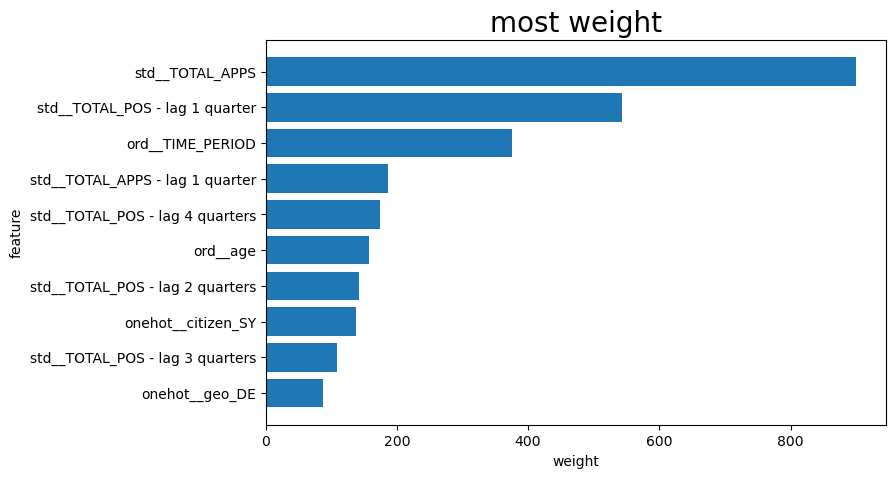

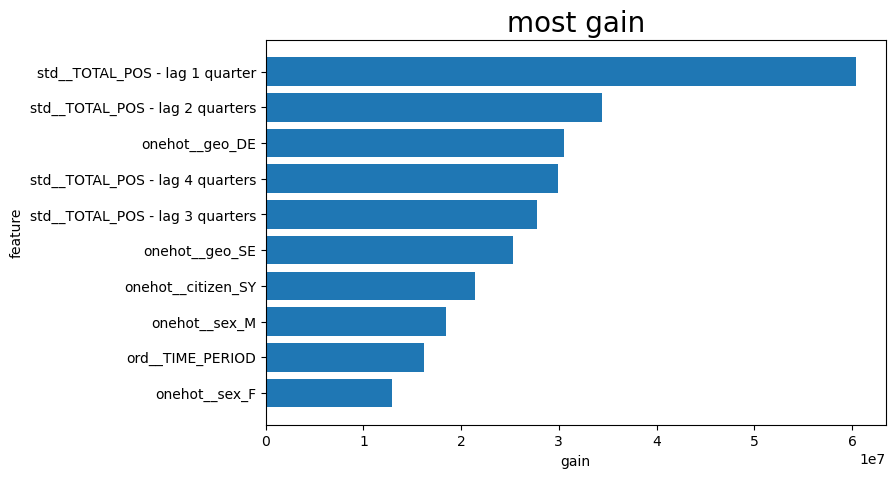

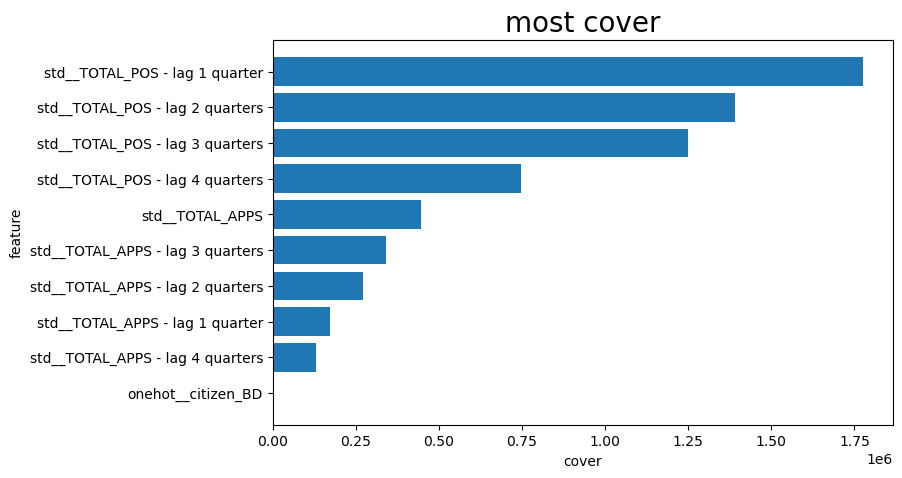

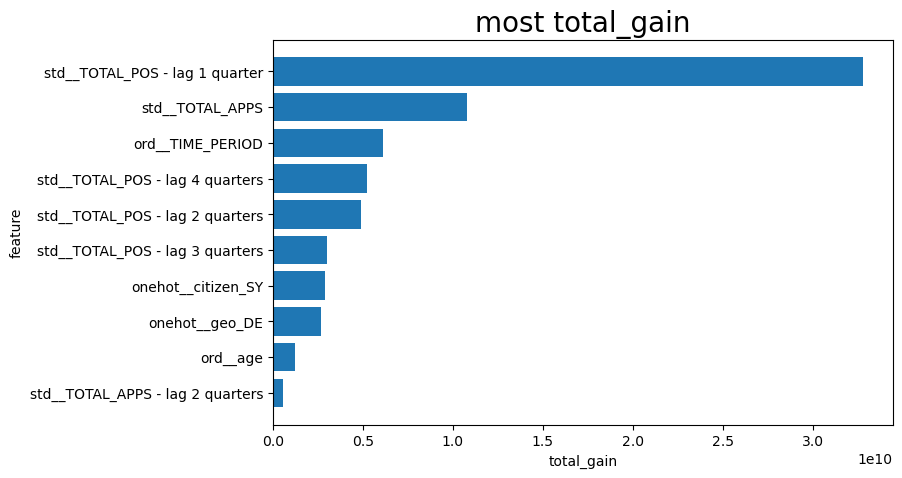

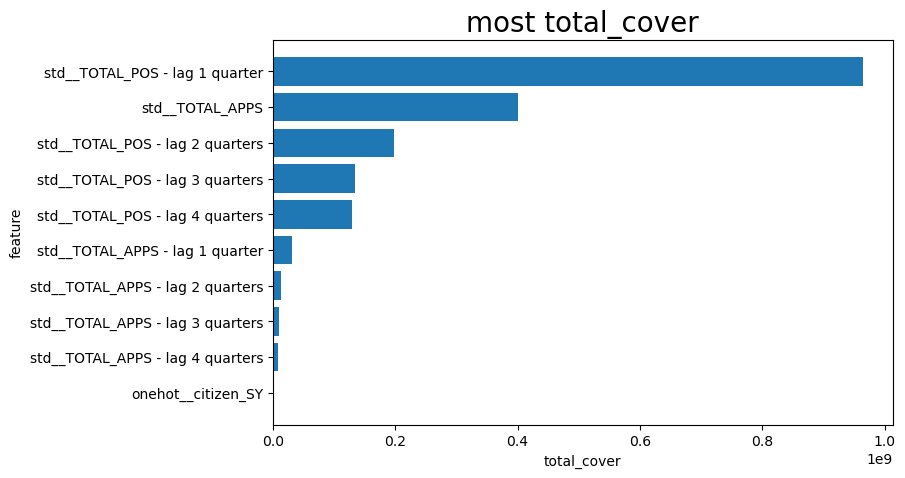

In [237]:
NUM_TO_SHOW = 10
for m in metric_list:
    sorted = metrics.sort_values(by=m, ascending=False)
    plt.figure(figsize=(8, 5))
    plt.barh(sorted.index[:NUM_TO_SHOW][::-1],sorted[m][:NUM_TO_SHOW][::-1])
    plt.xlabel(m)
    plt.ylabel('feature')
    plt.title('most ' + m, fontsize=20)
    plt.show()

In [238]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(preprocessor.transform(X_test))

shap.summary_plot(shap_values, feature_names=df_test.columns, max_display=10, title='Shap Summary Plot', plot_type='bar', show=False)


[00:23:47] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


KeyboardInterrupt: 

In [278]:
#XGB = joblib.load("../results/XGBRegressor(23:38 on 4-12-2023)[seed 1].pkl")
XGB = joblib.load("../results/XGBRegressor(0:14 on 4-12-2023).pkl")
explainer = shap.TreeExplainer(XGB)

[00:33:11] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [262]:
t = X_test.sample(np.floor(0.05 * len(X_test)).astype(int), random_state=14)


In [279]:
shap_values = explainer.shap_values(preprocessor.transform(t))

Text(0.5, 1.0, 'Shap Summary Plot')

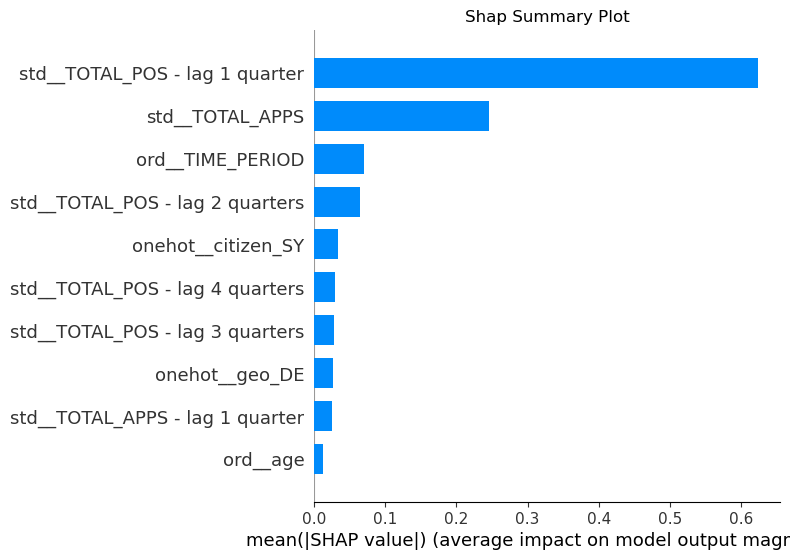

In [284]:
shap.summary_plot(shap_values, feature_names=preprocessor.get_feature_names_out(), max_display=10, title='Shap Summary Plot', plot_type='bar', show=False)
plt.title("Shap Summary Plot")


In [288]:
a[a["TOTAL_APPS"] > 0]

,index,citizen,sex,age,geo,TIME_PERIOD,TOTAL_APPS,TOTAL_POS - lag 1 quarter,TOTAL_POS - lag 2 quarters,TOTAL_POS - lag 3 quarters,TOTAL_POS - lag 4 quarters,TOTAL_APPS - lag 1 quarter,TOTAL_APPS - lag 2 quarters,TOTAL_APPS - lag 3 quarters,TOTAL_APPS - lag 4 quarters
13,954055,BY,UNK,Y18-34,LT,2021-Q3,5,0,0,0,0,0,0,0,0
31,2651644,HT,M,Y35-64,FR,2021-Q1,145,5,5,5,10,190,140,65,295
35,7192423,ZW,F,Y35-64,IE,2021-Q2,5,5,10,5,0,5,10,5,0
55,1766070,DZ,M,Y_LT14,FR,2021-Q3,20,0,5,5,0,20,55,70,35
106,2329235,GH,M,Y18-34,EL,2022-Q2,15,0,0,0,0,5,10,10,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64210,4203323,MR,F,Y18-34,ES,2021-Q4,5,0,0,0,0,0,0,0,0
64277,1363152,CO,F,Y_LT14,IT,2021-Q3,5,5,5,0,0,10,10,5,10
64281,5324273,RS,M,Y_LT14,FR,2022-Q4,30,5,0,5,0,40,45,40,30
64282,2649672,HT,M,Y18-34,FR,2022-Q2,195,25,40,65,40,145,225,620,295


In [259]:
#preprocessor.get_feature_names_out()

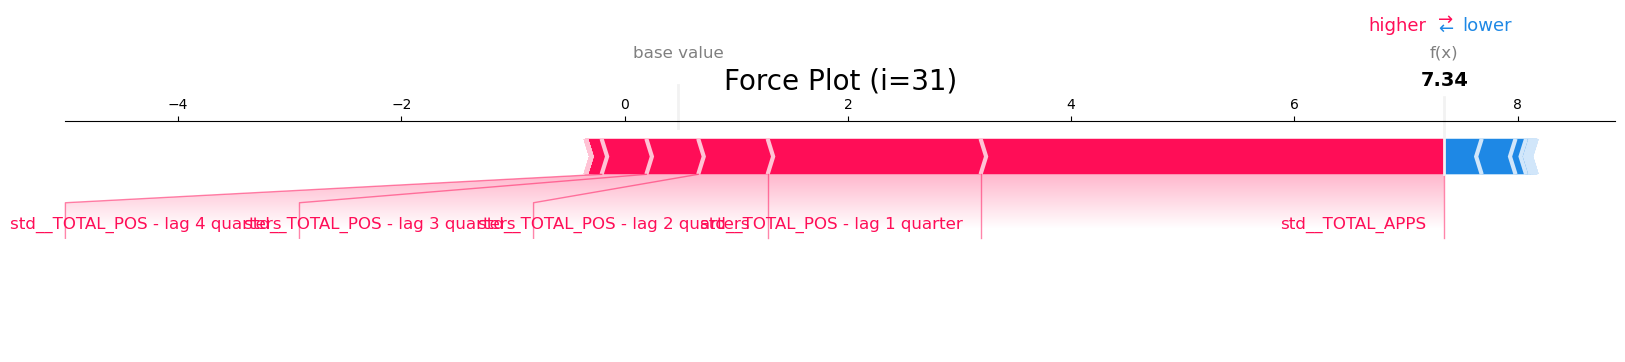

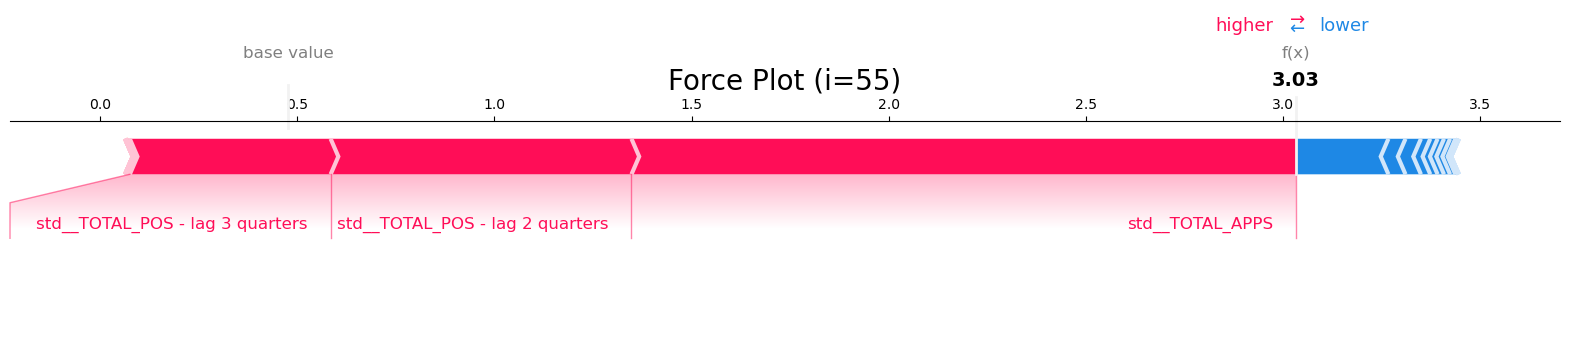

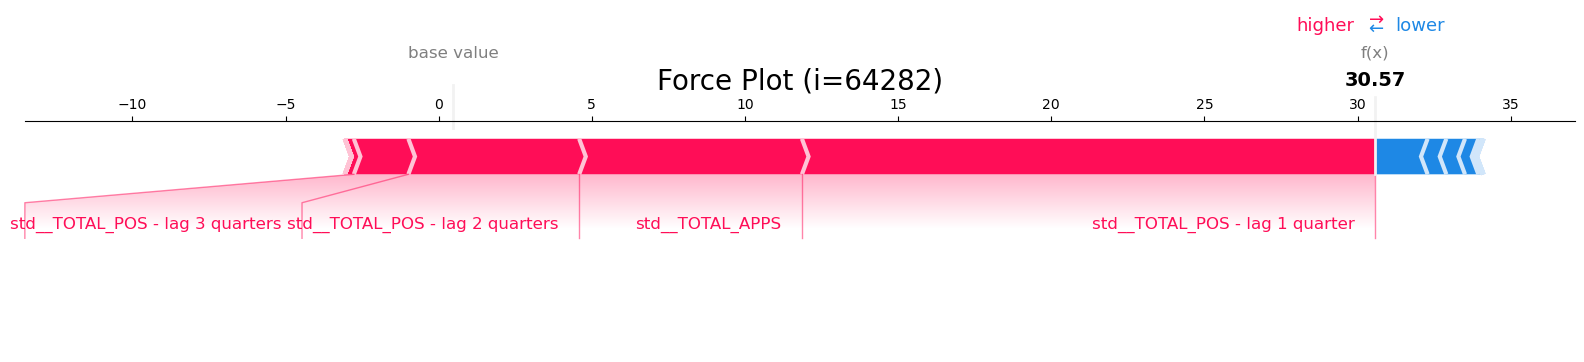

In [290]:
for i in [31, 55, 64282]:
    shap.plots.force(explainer.expected_value, shap_values[i], feature_names=feature_names, matplotlib=True, show=False)
    plt.title("Force Plot (i=" + str(i) + ")", fontsize=20)
    plt.show()

In [268]:
t[t["TOTAL_APPS"] > 0]

,citizen,sex,age,geo,TIME_PERIOD,TOTAL_APPS,TOTAL_POS - lag 1 quarter,TOTAL_POS - lag 2 quarters,TOTAL_POS - lag 3 quarters,TOTAL_POS - lag 4 quarters,TOTAL_APPS - lag 1 quarter,TOTAL_APPS - lag 2 quarters,TOTAL_APPS - lag 3 quarters,TOTAL_APPS - lag 4 quarters
954055,BY,UNK,Y18-34,LT,2021-Q3,5,0,0,0,0,0,0,0,0
2651644,HT,M,Y35-64,FR,2021-Q1,145,5,5,5,10,190,140,65,295
7192423,ZW,F,Y35-64,IE,2021-Q2,5,5,10,5,0,5,10,5,0
1766070,DZ,M,Y_LT14,FR,2021-Q3,20,0,5,5,0,20,55,70,35
2329235,GH,M,Y18-34,EL,2022-Q2,15,0,0,0,0,5,10,10,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4203323,MR,F,Y18-34,ES,2021-Q4,5,0,0,0,0,0,0,0,0
1363152,CO,F,Y_LT14,IT,2021-Q3,5,5,5,0,0,10,10,5,10
5324273,RS,M,Y_LT14,FR,2022-Q4,30,5,0,5,0,40,45,40,30
2649672,HT,M,Y18-34,FR,2022-Q2,195,25,40,65,40,145,225,620,295


In [273]:
t.loc[2651644]
a = t.reset_index()

In [276]:
a[a['index'] == 2651644]

,index,citizen,sex,age,geo,TIME_PERIOD,TOTAL_APPS,TOTAL_POS - lag 1 quarter,TOTAL_POS - lag 2 quarters,TOTAL_POS - lag 3 quarters,TOTAL_POS - lag 4 quarters,TOTAL_APPS - lag 1 quarter,TOTAL_APPS - lag 2 quarters,TOTAL_APPS - lag 3 quarters,TOTAL_APPS - lag 4 quarters
31,2651644,HT,M,Y35-64,FR,2021-Q1,145,5,5,5,10,190,140,65,295
